# IBM Applied Data Science - Battle of the neighborhoods

`Author` : Stéphane Degeye  `Last Update` : 2020-03-02

# Overview
This notebook aims to find the best location for opening a Lounge bar in Brussels. Foursquare data will be used to address this problem. As a final step, a DBSCAN "Clustering" will be performed to highlight certain neighborhoods.

![Bruxelles - Grand Place](Bruxelles.jpg "Bruxelles, Grand Place")

### Import Libraries

In [1]:
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np
from geopy.geocoders import Nominatim
from geopy.distance import geodesic 
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import folium
import requests
import json
import geopandas as gpd
from scipy.spatial import cKDTree
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
from pyproj import CRS
import re
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
import time
from pylab import rcParams
from urllib.parse import urlencode,unquote
from folium.plugins import MarkerCluster
import math
%matplotlib inline

<h2 id="City_Overview">City Overview</h2

<h3 id="Address">Address</h3

In [2]:
# Reference Location
address = 'Brussels,Belgium'

<h3 id="Reference Coordinates">Reference Coordinates</h3

In [3]:
# Coordinates of Reference Location
geolocator = Nominatim(user_agent="bruxelles_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of {} is [{},{}]'.format(address,latitude, longitude))

The geograpical coordinates of Brussels,Belgium is [50.8436709,4.3674366933879565]


<h3 id="Additional Coordinates">Additional Coordinates</h3

In [4]:
# Function for offsetting Latitude/Longitude coordinate with a distance parameter
# Foursquare return only a maximum of 100 Venues based on a Location/Radius (and other parameters of course)
# I will define 4 additionals Coordinates forming a rectangle with the Reference Coordinate as center
# So, Foursquare Request will be executed from 5 Coordinates (Reference Coordinate + 4 others)

def getNewLatLon(LatRef, LonRef, dn, de):

    # Earth’s radius
    radius=6378137

    # Coordinate offsets in radians
    dLat = dn/radius
    dLon = de/(radius*math.cos(math.pi*LatRef/180))

    # Offset Coordinates
    NewLat = LatRef + dLat * 180/math.pi
    Newlon = LonRef + dLon * 180/math.pi

    return (NewLat,Newlon)

In [5]:
nb_additional_coord = 4

# numpy arrays
Offset = np.empty(shape=[nb_additional_coord, 2])
Result = np.empty(shape=[nb_additional_coord, 2])

# dn/de for the 4 additionals Coordinates
Offset = [[-500,-800],[500,800],[-500,800],[500,-800]]

# Dataframe with Reference Coordinate
dfCoordRef = pd.DataFrame([{"Latitude" : latitude,"Longitude" : longitude}])

# Get New Latitude/Longitude based on Reference Coordinates and offsets
for i in range(nb_additional_coord):
    
    Result[i-1][0],Result[i-1][1] = getNewLatLon(latitude, longitude,Offset[i-1][0],Offset[i-1][1])

# Append Reference Coordinate with all others in a Dataframe

dfCoord = pd.DataFrame({'Latitude': Result[:, 0], 'Longitude': Result[:, 1]})
dfCoord = dfCoord.append(dfCoordRef, ignore_index = True)

dfCoord

,Latitude,Longitude
0,50.839179,4.356056
1,50.848162,4.378818
2,50.839179,4.378818
3,50.848162,4.356056
4,50.843671,4.367437


<h3 id="Map">Map</h3

In [6]:
# create map of city using latitude and longitude values
city_map = folium.Map(location=[latitude, longitude], zoom_start=13)


dfCoord.apply(lambda dfCoord:folium.CircleMarker(location=[dfCoord['Latitude'], 
                                                           dfCoord['Longitude']],
                                                           radius=5,
                                                           popup=dfCoord['Latitude'],
                                                           color='blue').add_to(city_map), axis=1)
city_map

<h2 id="Get_Foursquare_Venues">Get Foursquare Venues</h2

<h3 id="Define Foursquare Credentials and Version">Define Foursquare Credentials and Version</h3>

In [ ]:
CLIENT_ID = 'xxxxxxxx' 
CLIENT_SECRET = 'xxxxxxxx' 
VERSION = '20180605'

<h3 id="Define Function to explore">Define Function to explore</h3>

In [ ]:
# Function for exploring Venues from FourSquare 
def getNearbyVenues(name, lat, lng, qry,radius=2000,limit=500):
    
    venues_list=[]

    url = 'https://api.foursquare.com/v2/venues/explore'
    
    params = dict(client_id=CLIENT_ID, client_secret=CLIENT_SECRET,v=VERSION,
                  ll='{:f},{:f}'.format(lat,lng),
                  query=qry,
                  radius=radius,  
                  limit=limit
                   )
    
    results = requests.get(url=url,params=params).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    venues_list.append([( v['venue']['name'], 
                          v['venue']['location']['lat'], 
                          v['venue']['location']['lng'],  
                          v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    nearby_venues.columns = [ 'Venue', 
                              'Venue Latitude', 
                              'Venue Longitude', 
                              'Venue Category']
    
    return(nearby_venues)

<h3 id="Let's get some interresting Venues and save them to files">Let's get some interresting Venues and save them to files</h3>

In [ ]:
# Bars Venues

df_city_venues_Bar = pd.DataFrame()

for i in range (nb_additional_coord + 1):
  
    city_venues_Bar = getNearbyVenues(name='Bruxelles',
                                      lat=dfCoord.loc[i, "Latitude"],                                      
                                      lng=dfCoord.loc[i, "Longitude"],
                                      qry='bar')    
 
    df_city_venues_Bar = pd.concat([df_city_venues_Bar,city_venues_Bar]).drop_duplicates().reset_index(drop=True)
    
df_city_venues_Bar.to_csv('city_venues_Bar.csv') 

In [ ]:
# Parkings Venues

df_city_venues_Parking = pd.DataFrame()

for i in range (nb_additional_coord + 1):
  
    city_venues_Parking = getNearbyVenues(name='Bruxelles',
                                          lat=dfCoord.loc[i, "Latitude"],                                      
                                          lng=dfCoord.loc[i, "Longitude"],
                                          qry='parking')    
 
    df_city_venues_Parking = pd.concat([df_city_venues_Parking,city_venues_Parking]).drop_duplicates().reset_index(drop=True)
    
df_city_venues_Parking.to_csv('city_venues_Parking.csv') 

In [ ]:
# Schools Venues

df_city_venues_School = pd.DataFrame()

for i in range (nb_additional_coord + 1):
  
    city_venues_School = getNearbyVenues(name='Bruxelles',
                                         lat=dfCoord.loc[i, "Latitude"],                                      
                                         lng=dfCoord.loc[i, "Longitude"],
                                         qry='school')    
 
    df_city_venues_School = pd.concat([df_city_venues_School,city_venues_School]).drop_duplicates().reset_index(drop=True)
    
df_city_venues_School.to_csv('city_venues_School.csv') 

In [ ]:
# Restaurants Venues

df_city_venues_Restaurant = pd.DataFrame()

for i in range (nb_additional_coord + 1):
  
    city_venues_Restaurant = getNearbyVenues(name='Bruxelles',
                                             lat=dfCoord.loc[i, "Latitude"],                                      
                                             lng=dfCoord.loc[i, "Longitude"],
                                             qry='restaurant')    
 
    df_city_venues_Restaurant = pd.concat([df_city_venues_Restaurant,city_venues_Restaurant]).drop_duplicates().reset_index(drop=True)
    
df_city_venues_Restaurant.to_csv('city_venues_Restaurant.csv') 

In [ ]:
# Metro Stations Venues

df_city_venues_Metro = pd.DataFrame()

for i in range (nb_additional_coord + 1):
  
    city_venues_Metro = getNearbyVenues(name='Bruxelles',
                                        lat=dfCoord.loc[i, "Latitude"],                                      
                                        lng=dfCoord.loc[i, "Longitude"],
                                        qry='metro')    
 
    df_city_venues_Metro = pd.concat([df_city_venues_Metro,city_venues_Metro]).drop_duplicates().reset_index(drop=True)
    
df_city_venues_Metro.to_csv('city_venues_Metro.csv') 

<h3 id="Read previous saved Datasets">Read previous saved Datasets</h3>

In [7]:
city_venues_Bar = pd.read_csv('city_venues_Bar.csv')
city_venues_Bar.drop(['Unnamed: 0'],axis=1,inplace=True)
city_venues_Bar.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Goupil le Fol,50.845403,4.352287,Bar
1,Le Dillens,50.831825,4.349135,Bar
2,Enjoy Brussels,50.838000,4.359300,Bar
3,Monk,50.850166,4.347425,Bar
4,Café Bizon,50.848532,4.347709,Bar


In [8]:
city_venues_Parking = pd.read_csv('city_venues_Parking.csv')
city_venues_Parking.drop(['Unnamed: 0'],axis=1,inplace=True)
city_venues_Parking.drop(city_venues_Parking.loc[city_venues_Parking['Venue Category'] != 'Parking'].index, inplace=True)
city_venues_Parking.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parking Toison d'Or,50.837451,4.359342,Parking
1,Interparking,50.838096,4.352668,Parking
2,Parking Poelaert,50.837493,4.353179,Parking
3,Parking Boulevard de Waterloolaan,50.836655,4.357625,Parking
4,Parking Deux Portes,50.837973,4.359946,Parking


In [9]:
city_venues_School = pd.read_csv('city_venues_School.csv')
city_venues_School.drop(['Unnamed: 0'],axis=1,inplace=True)
city_venues_School.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alliance française de Bruxelles-Europe,50.842615,4.367413,Language School
1,Eurospeak,50.836444,4.360627,School
2,amira language school,50.839814,4.366747,School
3,Huis van het Nederlands,50.843246,4.347243,School
4,Sint-Jorisbasisschool,50.843541,4.349657,School


In [10]:
city_venues_Restaurant = pd.read_csv('city_venues_Restaurant.csv')
city_venues_Restaurant.drop(['Unnamed: 0'],axis=1,inplace=True)
city_venues_Restaurant.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Genco,50.841465,4.353083,Italian Restaurant
1,COCO Donuts,50.841219,4.355315,Donut Shop
2,Chez Richard,50.841357,4.353860,Gastropub
3,Au Vieux Saint Martin,50.840984,4.354737,Belgian Restaurant
4,À l'Ombre de la Ville,50.839149,4.360859,Italian Restaurant


In [11]:
city_venues_Metro = pd.read_csv('city_venues_Metro.csv')
city_venues_Metro.drop(['Unnamed: 0'],axis=1,inplace=True)
city_venues_Metro.drop(city_venues_Metro.loc[city_venues_Metro['Venue Category'] != 'Metro Station'].index, inplace=True)
city_venues_Metro.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parc / Park (STIB / MIVB) (Park (MIVB)),50.845634,4.362325,Metro Station
1,Naamsepoort / Porte de Namur (MIVB / STIB) (Na...,50.838246,4.361939,Metro Station
2,Trône / Troon (STIB / MIVB) (Troon (MIVB)),50.840669,4.366280,Metro Station
3,Louise / Louiza (STIB / MIVB) (Louiza (MIVB)),50.835620,4.355336,Metro Station
4,Centraal Station / Gare Centrale (MIVB / STIB)...,50.846440,4.358626,Metro Station


<h3 id="Let's view the different categories">Let's view the different categories</h3>

In [12]:
city_venues_Bar.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

Venue Category
Bar                         148
Cocktail Bar                 16
Wine Bar                     10
Pub                           9
Restaurant                    3
Tapas Restaurant              2
Hotel                         2
Irish Pub                     2
Music Venue                   2
Lounge                        1
Jazz Club                     1
Italian Restaurant            1
Mediterranean Restaurant      1
Pool Hall                     1
Deli / Bodega                 1
Concert Hall                  1
Coffee Shop                   1
Sports Bar                    1
Burger Joint                  1
Brasserie                     1
Bookstore                     1
Beer Bar                      1
Gastropub                     1
Name: Venue Category, dtype: int64

In [13]:
city_venues_Parking.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

Venue Category
Parking    90
Name: Venue Category, dtype: int64

In [14]:
city_venues_School.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

Venue Category
School                    53
Elementary School         36
High School               23
Nursery School             6
Language School            6
Music School               6
Adult Education Center     6
Middle School              2
Private School             2
Trade School               2
Driving School             2
Office                     1
Preschool                  1
Restaurant                 1
Daycare                    1
Dance Studio               1
Cultural Center            1
Coworking Space            1
College Classroom          1
College Arts Building      1
Art Gallery                1
University                 1
Name: Venue Category, dtype: int64

In [15]:
city_venues_Restaurant.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

Venue Category
Italian Restaurant               39
Restaurant                       18
Sandwich Place                   17
Belgian Restaurant               16
French Restaurant                13
Bakery                           13
Pizza Place                      11
Greek Restaurant                  9
Gastropub                         8
Thai Restaurant                   7
Seafood Restaurant                6
Brasserie                         6
Asian Restaurant                  6
Middle Eastern Restaurant         6
Café                              5
Mediterranean Restaurant          5
Snack Place                       4
Breakfast Spot                    4
Portuguese Restaurant             4
Fish & Chips Shop                 4
Japanese Restaurant               4
Indian Restaurant                 3
Vietnamese Restaurant             3
Vegetarian / Vegan Restaurant     3
Deli / Bodega                     3
Friterie                          3
Sushi Restaurant                  3
Steakhouse   

In [16]:
city_venues_Metro.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

Venue Category
Metro Station    33
Name: Venue Category, dtype: int64

<h2 id="Exploratory Data Analysis">Exploratory Data Analysis</h2

<h3 id="Convert Dataframe to GeoDataframe for further processing">Convert Dataframe to GeoDataframe for further processing</h3

In [17]:
# Convert to Geopandas GeoDataFrame
gdfBar = gpd.GeoDataFrame(city_venues_Bar, geometry=gpd.points_from_xy(city_venues_Bar['Venue Longitude'], city_venues_Bar['Venue Latitude']))
gdfBar.crs = "EPSG:4326"

gdfParking = gpd.GeoDataFrame(city_venues_Parking, geometry=gpd.points_from_xy(city_venues_Parking['Venue Longitude'], city_venues_Parking['Venue Latitude']))
gdfParking.crs = "EPSG:4326"

gdfSchool = gpd.GeoDataFrame(city_venues_School, geometry=gpd.points_from_xy(city_venues_School['Venue Longitude'], city_venues_School['Venue Latitude']))
gdfSchool.crs = "EPSG:4326"

gdfRestaurant = gpd.GeoDataFrame(city_venues_Restaurant, geometry=gpd.points_from_xy(city_venues_Restaurant['Venue Longitude'], city_venues_Restaurant['Venue Latitude']))
gdfRestaurant.crs = "EPSG:4326"

gdfMetro = gpd.GeoDataFrame(city_venues_Metro, geometry=gpd.points_from_xy(city_venues_Metro['Venue Longitude'], city_venues_Metro['Venue Latitude']))
gdfMetro.crs = "EPSG:4326"

<h3 id="Data Visualization">Data Visualization</h3

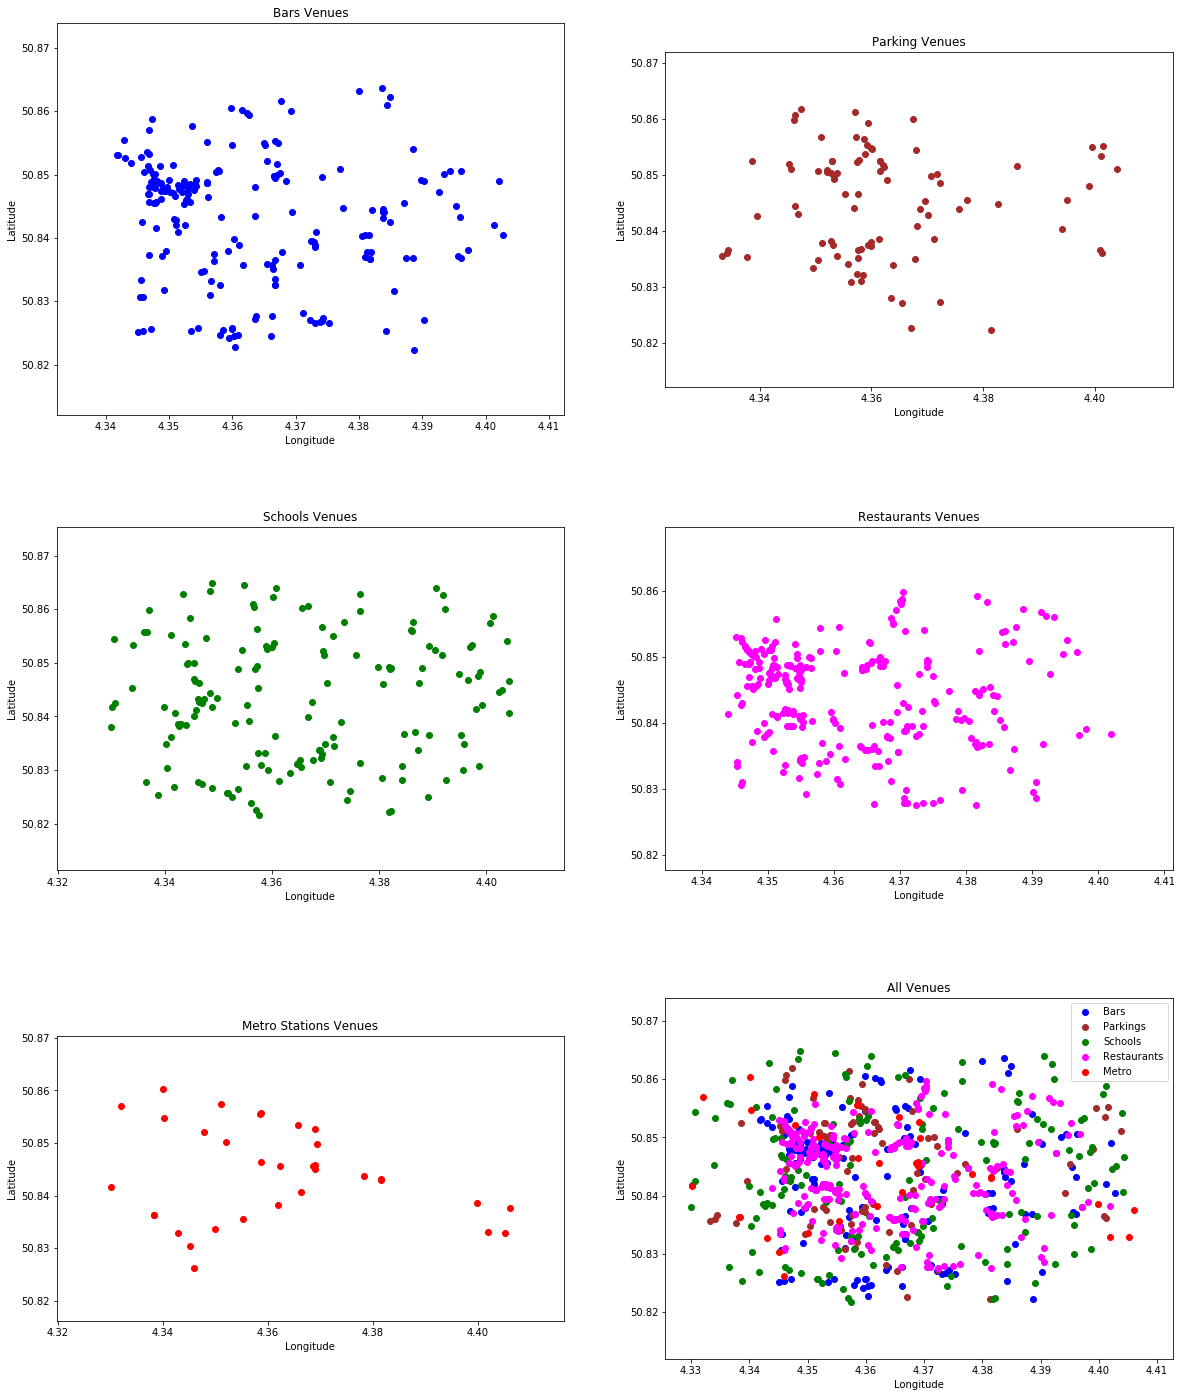

In [18]:
fig = plt.figure(figsize=(20,25)) # create figure

ax0 = fig.add_subplot(3, 2, 1) # add subplot 1 
ax1 = fig.add_subplot(3, 2, 2) # add subplot 2
ax2 = fig.add_subplot(3, 2, 3) # add subplot 3
ax3 = fig.add_subplot(3, 2, 4) # add subplot 4
ax4 = fig.add_subplot(3, 2, 5) # add subplot 5
ax5 = fig.add_subplot(3, 2, 6) # add subplot 6

# Subplot 1: Bars Venues
gdfBar.plot( color='blue', figsize=(20, 25), ax=ax0)
ax0.set_title('Bars Venues')
ax0.set_xlabel('Longitude')
ax0.set_ylabel('Latitude')

# Subplot 2: Parkings Venues
gdfParking.plot(color='brown', figsize=(20, 25), ax=ax1)
ax1.set_title('Parking Venues')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Subplot 3: Schools Venues
gdfSchool.plot(color='green', figsize=(20, 25), ax=ax2)
ax2.set_title('Schools Venues')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Subplot 4: Restaurants Venues
gdfRestaurant.plot( color='magenta', figsize=(20, 25), ax=ax3)
ax3.set_title('Restaurants Venues')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

# Subplot 5: Metro Stations Venues
gdfMetro.plot( color='red', figsize=(20, 25), ax=ax4)
ax4.set_title('Metro Stations Venues')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')

# Subplot 6: All Venues
gdfBar.plot( color='blue', figsize=(20, 25), ax=ax5)
gdfParking.plot(color='brown', figsize=(20, 25), ax=ax5)
gdfSchool.plot(color='green', figsize=(20, 25), ax=ax5)
gdfRestaurant.plot( color='magenta', figsize=(20, 25), ax=ax5)
gdfMetro.plot( color='red', figsize=(20, 25), ax=ax5)
ax5.set_title('All Venues')
ax5.set_xlabel('Longitude')
ax5.set_ylabel('Latitude')
plt.legend(["Bars", "Parkings", "Schools","Restaurants","Metro"])
plt.show()

<h2 id="Data Processing">Data Processing</h2

<h3 id="Data Reduction based on other Venues Max Distance's from Bar's Venues">Data Reduction based on other Venues Max Distance's from Bar's Venues</h3

In [19]:
# Function to get the value closest to another one and the distance between them
def nearest(row, geom_union, df1, df2, geom1_col='geometry', geom2_col='geometry', src_column=None):
    
    distances = []
    
    # Find the geometry that is closest
    nearest = df2[geom2_col] == nearest_points(row[geom1_col], geom_union)[1]
        
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = df2[nearest][src_column].to_numpy()[0]
       
    start_point = row['geometry']
    end_point_series = df2[nearest]['geometry']
    end_point = end_point_series.iloc[0]
    
    dist_to_point = start_point.distance(end_point)
    
    start_point_np = np.array(start_point)
    end_point_np = np.array(end_point)  
    
    start_point_np[[0, 1]] = start_point_np[[1, 0]]
    end_point_np[[0, 1]] = end_point_np[[1, 0]]
        
    dist_between_points = geodesic(start_point_np, end_point_np)
    
    distances.append(dist_between_points)
    
    return value,distances

In [20]:
# Get Centroid to use with nearest() function
gdfBar['centroid'] = gdfBar.centroid

<h3 id="Bar to Nearest Parking Distance">Bar to Nearest Parking Distance</h3

In [21]:
unary_union = gdfParking.unary_union

gdfBar['nearest_id_Parking','dist_to_Parking'] = gdfBar.apply(nearest, geom_union=unary_union, 
                                                        df1=gdfBar, df2=gdfParking, geom1_col='centroid', 
                                                        src_column='Venue', axis=1)

gdfBarSplit = pd.DataFrame([{x: y for x, y in enumerate(item)} for item in gdfBar[('nearest_id_Parking','dist_to_Parking')].values.tolist()], index=gdfBar.index)
gdfBarSplit.columns = ['nearest_id_Parking', 'dist_to_Parking']

gdfBarSplit['dist_to_Parking'] = re.findall(r"[-+]?\d*\.\d+|\d+", ' '.join([str(elem) for elem in gdfBarSplit['dist_to_Parking']]))

gdfBar['nearest_id_Parking'] = gdfBarSplit['nearest_id_Parking']
gdfBar['dist_to_Parking'] = gdfBarSplit['dist_to_Parking'].astype(float)
gdfBar.rename(columns={('nearest_id_Parking', 'dist_to_Parking'): "obsolete"},inplace=True)
gdfBar.drop('obsolete', axis=1, inplace=True)

<h3 id="Bar to Nearest School Distance">Bar to Nearest School Distance</h3

In [22]:
unary_union = gdfSchool.unary_union

gdfBar['nearest_id_School','dist_to_School'] = gdfBar.apply(nearest, geom_union=unary_union, 
                                                                  df1=gdfBar, df2=gdfSchool, geom1_col='centroid',
                                                                  src_column='Venue', axis=1)

gdfBarSplit = pd.DataFrame([{x: y for x, y in enumerate(item)} for item in gdfBar[('nearest_id_School','dist_to_School')].values.tolist()], index=gdfBar.index)
gdfBarSplit.columns = ['nearest_id_School', 'dist_to_School']

gdfBarSplit['dist_to_School'] = re.findall(r"[-+]?\d*\.\d+|\d+", ' '.join([str(elem) for elem in gdfBarSplit['dist_to_School']]))

gdfBar['nearest_id_School'] = gdfBarSplit['nearest_id_School']
gdfBar['dist_to_School'] = gdfBarSplit['dist_to_School'].astype(float)

gdfBar.rename(columns={('nearest_id_School', 'dist_to_School'): "obsolete"},inplace=True)
gdfBar.drop('obsolete', axis=1, inplace=True)

<h3 id="Bar to Nearest Restaurant Distance">Bar to Nearest Restaurant Distance</h3

In [23]:
unary_union = gdfRestaurant.unary_union

gdfBar['nearest_id_Restaurant','dist_to_Restaurant'] = gdfBar.apply(nearest, geom_union=unary_union, 
                                                                  df1=gdfBar, df2=gdfRestaurant, geom1_col='centroid',
                                                                  src_column='Venue', axis=1)

gdfBarSplit = pd.DataFrame([{x: y for x, y in enumerate(item)} for item in gdfBar[('nearest_id_Restaurant','dist_to_Restaurant')].values.tolist()], index=gdfBar.index)
gdfBarSplit.columns = ['nearest_id_Restaurant', 'dist_to_Restaurant']

gdfBarSplit['dist_to_Restaurant'] = re.findall(r"[-+]?\d*\.\d+|\d+", ' '.join([str(elem) for elem in gdfBarSplit['dist_to_Restaurant']]))

gdfBar['nearest_id_Restaurant'] = gdfBarSplit['nearest_id_Restaurant']
gdfBar['dist_to_Restaurant'] = gdfBarSplit['dist_to_Restaurant'].astype(float)

gdfBar.rename(columns={('nearest_id_Restaurant', 'dist_to_Restaurant'): "obsolete"},inplace=True)
gdfBar.drop('obsolete', axis=1, inplace=True)

<h3 id="Bar to Nearest Metro Distance">Bar to Nearest Metro Distance</h3

In [24]:
unary_union = gdfMetro.unary_union

gdfBar['nearest_id_Metro','dist_to_Metro'] = gdfBar.apply(nearest, geom_union=unary_union, 
                                                                  df1=gdfBar, df2=gdfMetro, geom1_col='centroid',
                                                                  src_column='Venue', axis=1)

gdfBarSplit = pd.DataFrame([{x: y for x, y in enumerate(item)} for item in gdfBar[('nearest_id_Metro','dist_to_Metro')].values.tolist()], index=gdfBar.index)
gdfBarSplit.columns = ['nearest_id_Metro', 'dist_to_Metro']

gdfBarSplit['dist_to_Metro'] = re.findall(r"[-+]?\d*\.\d+|\d+", ' '.join([str(elem) for elem in gdfBarSplit['dist_to_Metro']]))

gdfBar['nearest_id_Metro'] = gdfBarSplit['nearest_id_Metro']
gdfBar['dist_to_Metro'] = gdfBarSplit['dist_to_Metro'].astype(float)

gdfBar.rename(columns={('nearest_id_Metro', 'dist_to_Metro'): "obsolete"},inplace=True)
gdfBar.drop('obsolete', axis=1, inplace=True)

<h3 id="Max Distance criteria from "Bars" Venue to Nearest other Venues">Max Distance criteria from "Bars" Venue to Nearest other Venues</h3

In [25]:
# Maximum Distance (m) parameters
MaxDistBar_Parking = 0.5
MaxDistBar_School = 0.5
MaxDistBar_Restaurant = 0.5
MaxDistBar_Metro = 0.5

In [26]:
# Convert Distances values to float
gdfBar['dist_to_Parking'] = gdfBar['dist_to_Parking'].astype(float)
gdfBar['dist_to_School'] = gdfBar['dist_to_School'].astype(float)
gdfBar['dist_to_Restaurant'] = gdfBar['dist_to_Restaurant'].astype(float)
gdfBar['dist_to_Metro'] = gdfBar['dist_to_Metro'].astype(float)

In [27]:
gdfResult =  gdfBar.loc[(gdfBar['dist_to_Parking'] <= MaxDistBar_Parking)
                        & (gdfBar['dist_to_School'] <= MaxDistBar_School)
                        & (gdfBar['dist_to_Restaurant'] <= MaxDistBar_Restaurant)
                        & (gdfBar['dist_to_Metro'] <= MaxDistBar_Metro)]

In [28]:
gdfResult.shape

(125, 14)

In [29]:
gdfResult

,Venue,Venue Latitude,Venue Longitude,Venue Category,geometry,centroid,nearest_id_Parking,dist_to_Parking,nearest_id_School,dist_to_School,nearest_id_Restaurant,dist_to_Restaurant,nearest_id_Metro,dist_to_Metro
1,Le Dillens,50.831825,4.349135,Bar,POINT (4.34914 50.83183),POINT (4.34914 50.83183),Interparking,0.175794,Athénée Royal Victor Horta,0.489978,La Braise,0.231491,Munthof / Hôtel des Monnaies (MIVB / STIB) (Mu...,0.203644
2,Enjoy Brussels,50.838000,4.359300,Bar,POINT (4.35930 50.83800),POINT (4.35930 50.83800),Parking Toison d'Or,0.061142,Eurospeak,0.196720,Chyl Cafe,0.150540,Naamsepoort / Porte de Namur (MIVB / STIB) (Na...,0.187923
3,Monk,50.850166,4.347425,Bar,POINT (4.34742 50.85017),POINT (4.34742 50.85017),Q-Park Dansaert,0.164022,Maria-Boodschaplyceum,0.146686,ABC Poissonerie,0.017510,Sainte-Catherine / Sint-Katelijne (MIVB / STIB...,0.223768
4,Café Bizon,50.848532,4.347709,Bar,POINT (4.34771 50.84853),POINT (4.34771 50.84853),Q-Park Dansaert,0.322795,Instituut Anneessens Funck,0.274556,Fanny Thai,0.045135,Sainte-Catherine / Sint-Katelijne (MIVB / STIB...,0.403853
5,Bar des Amis,50.850042,4.347845,Bar,POINT (4.34784 50.85004),POINT (4.34784 50.85004),Q-Park Dansaert,0.195663,Maria-Boodschaplyceum,0.174745,Frites Atelier,0.001478,Sainte-Catherine / Sint-Katelijne (MIVB / STIB...,0.235794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,Affligem Café,50.847755,4.348977,Pub,POINT (4.34898 50.84775),POINT (4.34898 50.84775),Interparking,0.342892,Instituut Anneessens Funck,0.253419,Yi Chan,0.059938,De Brouckère (MIVB / STIB | De Lijn) (De Brouc...,0.342138
203,Gecko,50.848013,4.346808,Cocktail Bar,POINT (4.34681 50.84801),POINT (4.34681 50.84801),Q-Park Dansaert,0.355731,Athénée Léon Lepage (Atheneum Léon Lepage),0.149666,Publico,0.091424,Sainte-Catherine / Sint-Katelijne (MIVB / STIB...,0.467059
205,Life Is Beautiful - Cocktail Bar,50.852547,4.343006,Cocktail Bar,POINT (4.34301 50.85255),POINT (4.34301 50.85255),Q-Park Lepage,0.175955,Mabo Basisschool,0.122050,Henri,0.153840,Comte de Flandre / Graaf van Vlaanderen (STIB ...,0.311571
206,Quai des Bananes,50.847280,4.350161,Cocktail Bar,POINT (4.35016 50.84728),POINT (4.35016 50.84728),Interparking,0.380632,Sint-Joris Basisschool,0.348212,Manhattn's Burgers,0.024798,De Brouckère (MIVB / STIB | De Lijn) (De Brouc...,0.344979


In [30]:
Parking = gdfResult['nearest_id_Parking'].unique()
gdfResultParking = gdfParking[gdfParking['Venue'].isin(Parking)]
gdfResultParking

,Venue,Venue Latitude,Venue Longitude,Venue Category,geometry
0,Parking Toison d'Or,50.837451,4.359342,Parking,POINT (4.35934 50.83745)
1,Interparking,50.838096,4.352668,Parking,POINT (4.35267 50.83810)
3,Parking Boulevard de Waterloolaan,50.836655,4.357625,Parking,POINT (4.35763 50.83666)
5,Interparking,50.836779,4.358202,Parking,POINT (4.35820 50.83678)
6,Interparking,50.837217,4.359879,Parking,POINT (4.35988 50.83722)
7,Interparking,50.838534,4.361281,Parking,POINT (4.36128 50.83853)
8,Parking advocaten justitiepaleis,50.837782,4.351149,Parking,POINT (4.35115 50.83778)
11,BePark Place du Luxembourg (Hôtel Renaissance),50.838600,4.371160,Parking,POINT (4.37116 50.83860)
12,Parking Albertine,50.844177,4.356809,Parking,POINT (4.35681 50.84418)
13,Zenpark,50.834143,4.355746,Parking,POINT (4.35575 50.83414)


In [31]:
School = gdfResult['nearest_id_School'].unique()
gdfResultSchool = gdfSchool[gdfSchool['Venue'].isin(School)]
gdfResultSchool

,Venue,Venue Latitude,Venue Longitude,Venue Category,geometry
0,Alliance française de Bruxelles-Europe,50.842615,4.367413,Language School,POINT (4.36741 50.84262)
1,Eurospeak,50.836444,4.360627,School,POINT (4.36063 50.83644)
2,amira language school,50.839814,4.366747,School,POINT (4.36675 50.83981)
4,Sint-Jorisbasisschool,50.843541,4.349657,School,POINT (4.34966 50.84354)
5,Train@Rail,50.845332,4.357333,School,POINT (4.35733 50.84533)
7,Haute École Fransisco Ferrer - Terre Neuve 🎓,50.840081,4.345422,School,POINT (4.34542 50.84008)
10,Instituut Anneessens Funck,50.840713,4.341867,School,POINT (4.34187 50.84071)
11,Instituut Anneessens Funck,50.846230,4.346303,School,POINT (4.34630 50.84623)
13,conservatoire maison Béjart,50.848853,4.353699,School,POINT (4.35370 50.84885)
15,Athénée Léon Lepage (Atheneum Léon Lepage),50.846946,4.345514,School,POINT (4.34551 50.84695)


In [32]:
Restaurant = gdfResult['nearest_id_Restaurant'].unique()
gdfResultRestaurant = gdfRestaurant[gdfRestaurant['Venue'].isin(Restaurant)]
gdfResultRestaurant

,Venue,Venue Latitude,Venue Longitude,Venue Category,geometry
4,À l'Ombre de la Ville,50.839149,4.360859,Italian Restaurant,POINT (4.36086 50.83915)
16,Le Pain Quotidien,50.840040,4.355360,Bakery,POINT (4.35536 50.84004)
22,Shuka,50.836485,4.360712,Restaurant,POINT (4.36071 50.83648)
23,Peck 20,50.834576,4.355060,Breakfast Spot,POINT (4.35506 50.83458)
25,El Fontan,50.837812,4.349389,Tapas Restaurant,POINT (4.34939 50.83781)
...,...,...,...,...,...
269,Yi Chan,50.848247,4.348632,Vietnamese Restaurant,POINT (4.34863 50.84825)
270,Beaucoup Fish,50.855675,4.351225,Restaurant,POINT (4.35122 50.85568)
271,Henri,50.852959,4.345091,Belgian Restaurant,POINT (4.34509 50.85296)
272,Atelier des Pâtes,50.841623,4.359504,Italian Restaurant,POINT (4.35950 50.84162)


In [33]:
Metro = gdfResult['nearest_id_Metro'].unique()
gdfResultMetro = gdfMetro[gdfMetro['Venue'].isin(Metro)]
gdfResultMetro

,Venue,Venue Latitude,Venue Longitude,Venue Category,geometry
0,Parc / Park (STIB / MIVB) (Park (MIVB)),50.845634,4.362325,Metro Station,POINT (4.36233 50.84563)
1,Naamsepoort / Porte de Namur (MIVB / STIB) (Na...,50.838246,4.361939,Metro Station,POINT (4.36194 50.83825)
2,Trône / Troon (STIB / MIVB) (Troon (MIVB)),50.840669,4.366280,Metro Station,POINT (4.36628 50.84067)
3,Louise / Louiza (STIB / MIVB) (Louiza (MIVB)),50.835620,4.355336,Metro Station,POINT (4.35534 50.83562)
4,Centraal Station / Gare Centrale (MIVB / STIB)...,50.846440,4.358626,Metro Station,POINT (4.35863 50.84644)
5,Munthof / Hôtel des Monnaies (MIVB / STIB) (Mu...,50.833567,4.350027,Metro Station,POINT (4.35003 50.83357)
6,De Brouckère (MIVB / STIB | De Lijn) (De Brouc...,50.850147,4.352030,Metro Station,POINT (4.35203 50.85015)
10,Métro 1 Gare de l'Ouest > Stockel (STIB) / Met...,50.845152,4.368958,Metro Station,POINT (4.36896 50.84515)
12,Sainte-Catherine / Sint-Katelijne (MIVB / STIB...,50.852161,4.347829,Metro Station,POINT (4.34783 50.85216)
13,Botanique / Kruidtuin (STIB / MIVB | De Lijn) ...,50.853463,4.365758,Metro Station,POINT (4.36576 50.85346)


<h3 id="Concatenation of "Bars" Venues with all others closest venues">Concatenation of "Bars" Venues with all others closest Venues</h3

In [34]:
gdfResult = pd.concat([gdfResult,gdfResultParking], axis=0, ignore_index=False,sort=True)

In [35]:
gdfResult = pd.concat([gdfResult,gdfResultSchool], axis=0, ignore_index=False,sort=True)

In [36]:
gdfResult = pd.concat([gdfResult,gdfResultRestaurant], axis=0, ignore_index=False,sort=True)

In [37]:
gdfResult = pd.concat([gdfResult,gdfResultMetro], axis=0, ignore_index=False,sort=True)

<h2 id="Data Clustering">Data Clustering</h2

In [38]:
# We keep only usefull features for algorithm
X = gdfResult[['Venue Latitude','Venue Longitude']]

<h3 id="DBSCAN Algorithm">DBSCAN Algorithm</h3

In [39]:
import sklearn.utils
sklearn.utils.check_random_state(1000)
Clus_dataSet = X[['Venue Latitude','Venue Longitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

In [40]:
# Compute DBSCAN
db = DBSCAN(eps=0.15, min_samples=7).fit(Clus_dataSet)
labels = db.labels_

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

clusterNum

8

In [41]:
gdfResult["labels"]=labels

In [42]:
colorsList = ['purple','darkblue','red','green','yellow','orange','cadetblue','darkred','darkgreen',            
              'gray','lightgray','lightred','pink','white','black']

m = folium.Map(location=[gdfResult['Venue Latitude'].mean(),gdfResult['Venue Longitude'].mean()],zoom_start=14)

gdfResult.apply(lambda row:folium.CircleMarker(location=[row['Venue Latitude'], row['Venue Longitude']],radius=5, popup=row['Venue'],
                                               color=colorsList[row['labels']]).add_to(m), axis=1)

m

In [43]:
unique_labels = set(labels)
unique_labels

{-1, 0, 1, 2, 3, 4, 5, 6}

In [46]:
# Firts, create an array of booleans using the labels from db.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

In [44]:
# Create colors for the clusters.
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

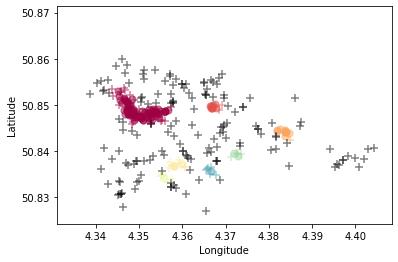

In [47]:
# Plot the points with colors
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)
    
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
       
    # Plot the datapoints that are clustered
    xy = X[class_member_mask & core_samples_mask]
    plt.scatter(xy.iloc[:, 1], xy.iloc[:, 0],s=50, c=[col], marker=u'o', alpha=0.5)
        
    # Plot the outliers
    xy = X[class_member_mask & ~core_samples_mask]
    plt.scatter(xy.iloc[:, 1], xy.iloc[:, 0],s=50, c=[col], marker=u'+', alpha=0.5)
 

In [48]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 7
Estimated number of noise points: 158


<h3 id="Clusters Analysis">Clusters Analysis</h3

<h3 id="Outliers">Outliers</h3

In [49]:
dfOutliers = gdfResult.loc[gdfResult['labels'] == -1]
dfOutliers = dfOutliers.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False).to_frame(name="Outliers")
dfOutliers.reset_index()

,Venue Category,Outliers
0,Parking,33
1,Bar,29
2,Metro Station,18
3,School,10
4,High School,7
5,Italian Restaurant,7
6,Restaurant,6
7,Language School,4
8,Cocktail Bar,4
9,Wine Bar,3


<h3 id="Cluster 0">Cluster 0</h3

In [50]:
dfCluster0 = gdfResult.loc[gdfResult['labels'] == 0]
dfCluster0 = dfCluster0.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False).to_frame(name="Cluster 0")
dfCluster0.reset_index()

,Venue Category,Cluster 0
0,Bar,40
1,Belgian Restaurant,5
2,Pub,5
3,Cocktail Bar,4
4,Bakery,4
5,Parking,4
6,Seafood Restaurant,3
7,Gastropub,2
8,Asian Restaurant,2
9,Tapas Restaurant,2


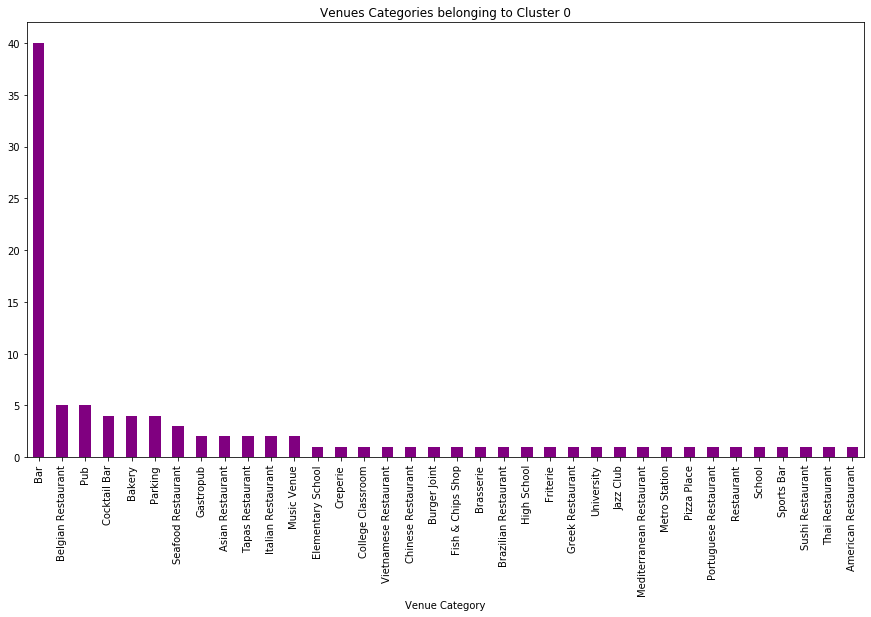

In [51]:
dfCluster0['Cluster 0'].plot(kind='bar',figsize=(15, 8),color='purple')
plt.title('Venues Categories belonging to Cluster 0') 
plt.show()

<h3 id="Cluster 1">Cluster 1</h3

In [52]:
dfCluster1 = gdfResult.loc[gdfResult['labels'] == 1]
dfCluster1 = dfCluster1.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False).to_frame(name="Cluster 1")
dfCluster1.reset_index()

,Venue Category,Cluster 1
0,Bar,5
1,Deli / Bodega,2
2,Metro Station,1
3,Italian Restaurant,1
4,Asian Restaurant,1
5,African Restaurant,1


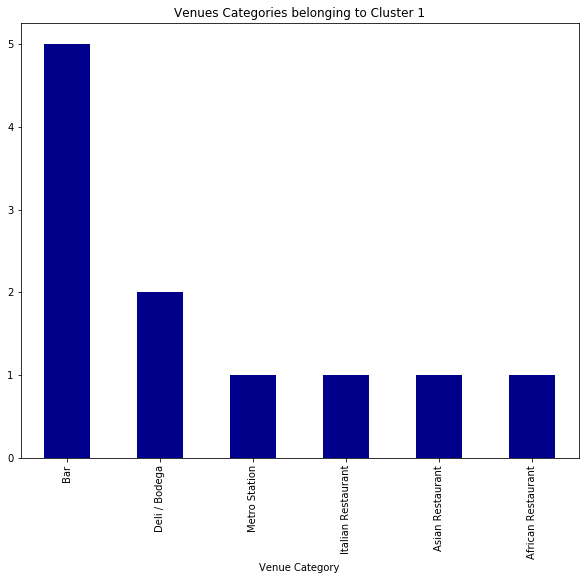

In [53]:
dfCluster1['Cluster 1'].plot(kind='bar',figsize=(10, 8),color='darkblue')
plt.title('Venues Categories belonging to Cluster 1') 
plt.show()

<h3 id="Cluster 2">Cluster 2</h3

In [54]:
dfCluster2 = gdfResult.loc[gdfResult['labels'] == 2]
dfCluster2 = dfCluster2.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False).to_frame(name="Cluster 2")
dfCluster2.reset_index()

,Venue Category,Cluster 2
0,Bar,4
1,Wine Bar,2
2,Vegetarian / Vegan Restaurant,1
3,Pub,1
4,Parking,1
5,Italian Restaurant,1
6,Irish Pub,1
7,Greek Restaurant,1


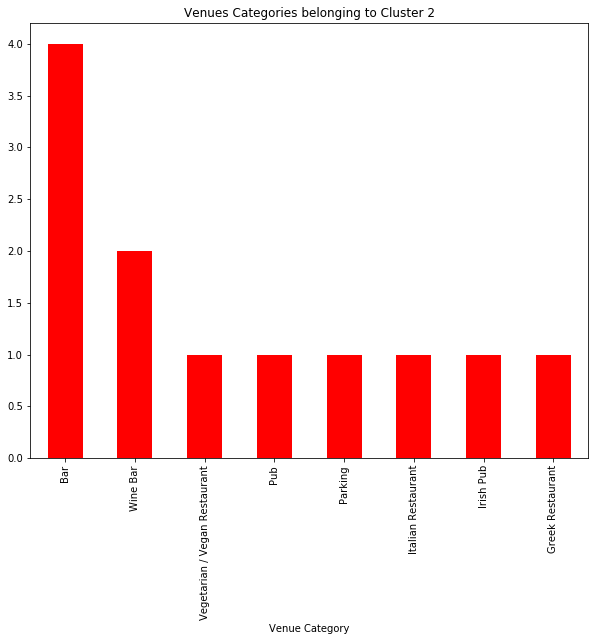

In [55]:
dfCluster2['Cluster 2'].plot(kind='bar',figsize=(10, 8),color='red')
plt.title('Venues Categories belonging to Cluster 2') 
plt.show()

<h3 id="Cluster 3">Cluster 3</h3

In [56]:
dfCluster3 = gdfResult.loc[gdfResult['labels'] == 3]
dfCluster3 = dfCluster3.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False).to_frame(name="Cluster 3")
dfCluster3.reset_index()

,Venue Category,Cluster 3
0,Parking,4
1,School,1
2,Restaurant,1
3,Lounge,1
4,Cocktail Bar,1
5,Belgian Restaurant,1
6,Bar,1


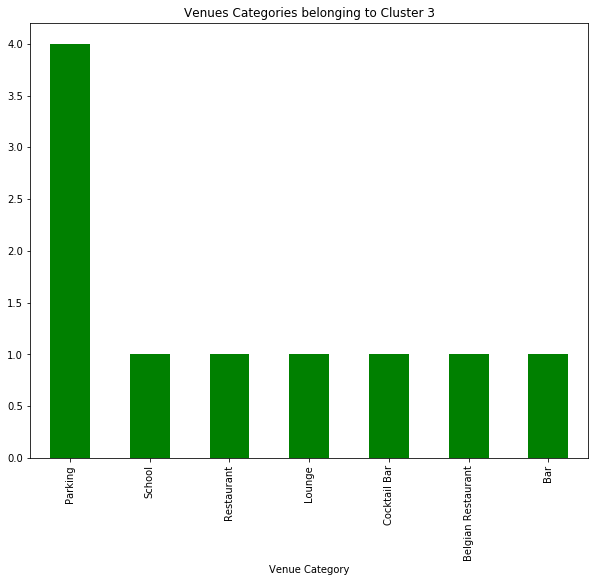

In [57]:
dfCluster3['Cluster 3'].plot(kind='bar',figsize=(10, 8),color='green')
plt.title('Venues Categories belonging to Cluster 3') 
plt.show()

<h3 id="Cluster 4">Cluster 4</h3

In [58]:
dfCluster4 = gdfResult.loc[gdfResult['labels'] == 4]
dfCluster4 = dfCluster4.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False).to_frame(name="Cluster 4")
dfCluster4.reset_index()

,Venue Category,Cluster 4
0,Bar,2
1,Salad Place,1
2,Pub,1
3,Parking,1
4,Breakfast Spot,1
5,Bakery,1


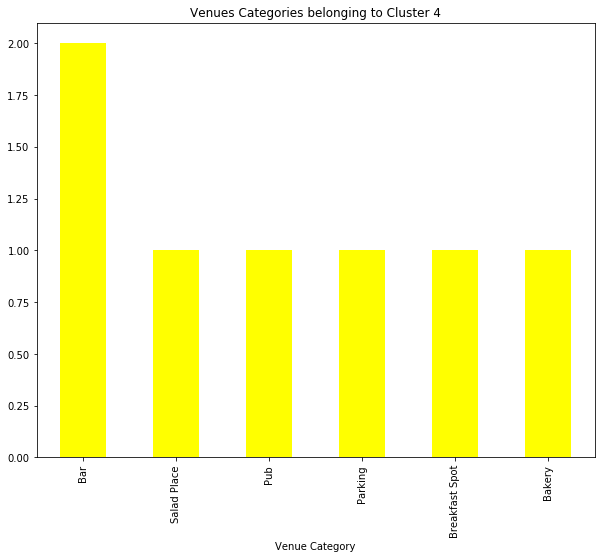

In [59]:
dfCluster4['Cluster 4'].plot(kind='bar',figsize=(10, 8),color='yellow')
plt.title('Venues Categories belonging to Cluster 4') 
plt.show()

<h3 id="Cluster 5">Cluster 5</h3

In [60]:
dfCluster5 = gdfResult.loc[gdfResult['labels'] == 5]
dfCluster5 = dfCluster5.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False).to_frame(name="Cluster 5")
dfCluster5.reset_index()

,Venue Category,Cluster 5
0,Bar,2
1,School,1
2,Sandwich Place,1
3,Parking,1
4,Fish & Chips Shop,1
5,Cocktail Bar,1


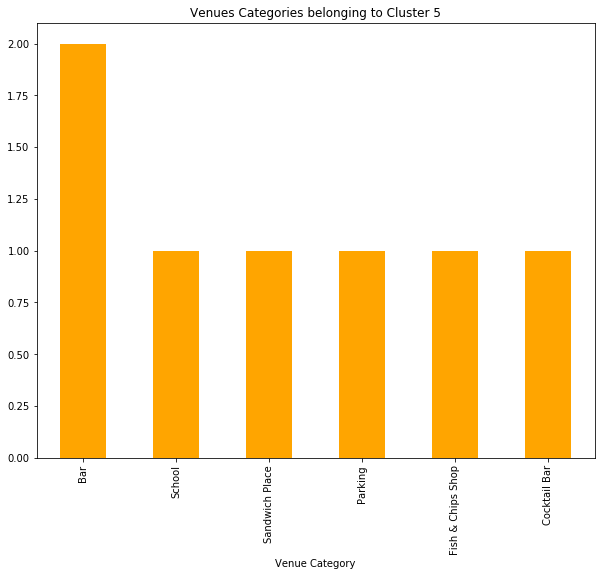

In [61]:
dfCluster5['Cluster 5'].plot(kind='bar',figsize=(10, 8),color='orange')
plt.title('Venues Categories belonging to Cluster 5') 
plt.show()

<h3 id="Cluster 6">Cluster 6</h3

In [62]:
dfCluster6 = gdfResult.loc[gdfResult['labels'] == 6]
dfCluster6 = dfCluster6.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False).to_frame(name="Cluster 6")
dfCluster6.reset_index()

,Venue Category,Cluster 6
0,Bar,2
1,Trattoria/Osteria,1
2,Pool Hall,1
3,Parking,1
4,Italian Restaurant,1
5,African Restaurant,1


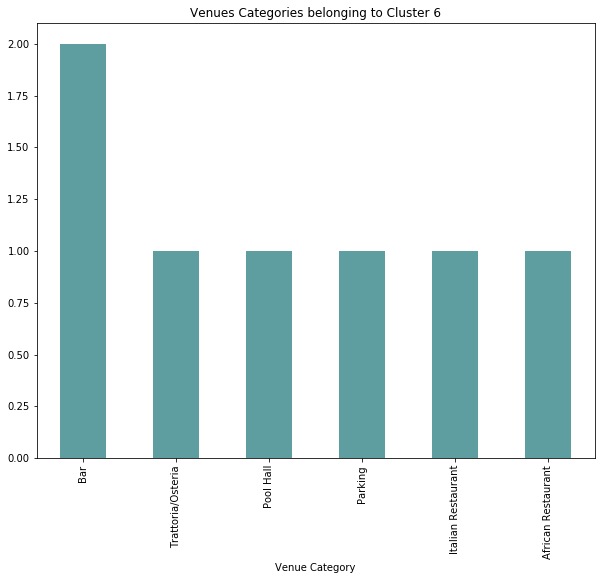

In [63]:
dfCluster6['Cluster 6'].plot(kind='bar',figsize=(10, 8),color='cadetblue')
plt.title('Venues Categories belonging to Cluster 6') 
plt.show()